In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.regression.linear_model import OLS
from scipy.signal import periodogram

## Loading data

,Year,Month,Day,Temperature
Date,,,,
1756-01-01,1756,1,1,-8.7
1756-01-02,1756,1,2,-9.2
1756-01-03,1756,1,3,-8.6
1756-01-04,1756,1,4,-7.7
1756-01-05,1756,1,5,-7.2
...,...,...,...,...
2017-12-27,2017,12,27,2.5
2017-12-28,2017,12,28,3.8
2017-12-29,2017,12,29,2.4


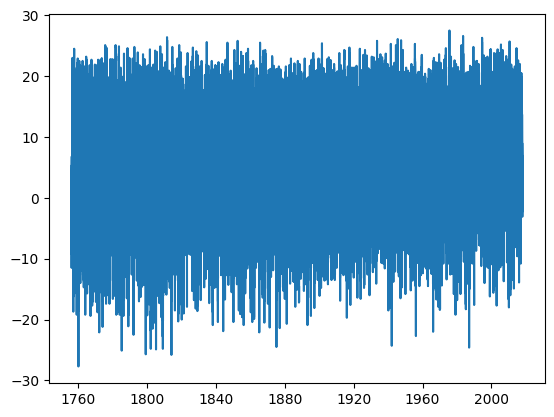

In [59]:
data=pd.read_csv("stockholm_daily_mean_temperature_1756_2017.txt",sep="\s+",header=None,usecols=[0,1,2,5],names=["Year","Month","Day","Temperature"])
data["Date"]=pd.to_datetime(data[["Year","Month","Day"]])
data.set_index("Date",inplace=True)
display(data)
plt.plot(data.index,data["Temperature"])
plt.show()


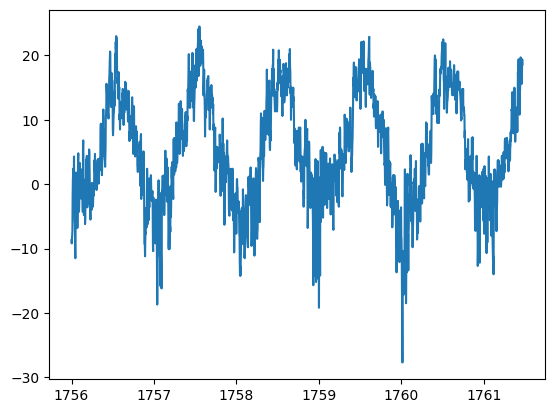

In [60]:
#Zooming in looking for periodicty
first_samples=data.head(2000)
plt.plot(first_samples.index,first_samples["Temperature"])
plt.show()

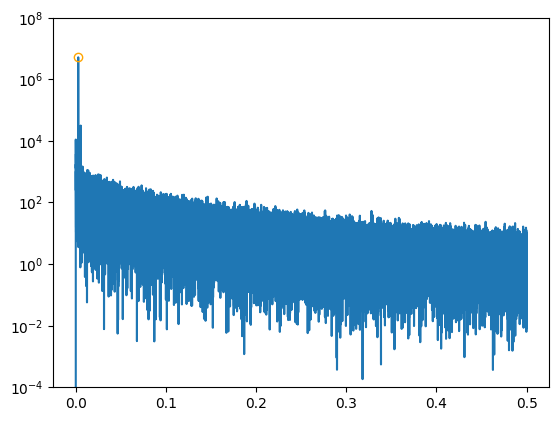

The peak is at 0.0027378937028444835 which corresponds to a period of 365.2442748091603 days.


In [61]:

f, px =periodogram(data["Temperature"])
plt.plot(f,px)
plt.yscale("log")
plt.ylim([1E-4,1E8])
max_p=np.max(px)
max_f=f[np.argmax(px)]
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.show()
print("The peak is at",max_f,"which corresponds to a period of",1/max_f,"days.")

## Cleaning the data

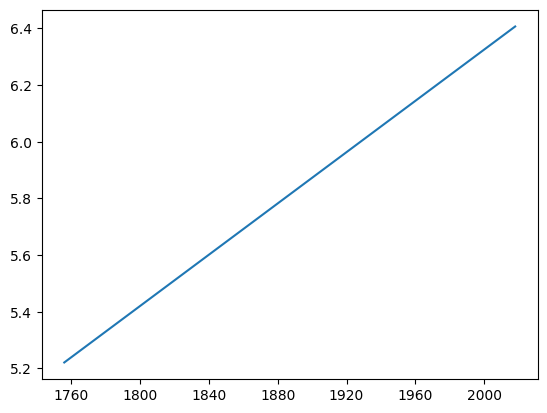

In [62]:
#Removing linear trend
data_detrended=detrend(data["Temperature"],order=1)
#We can see the linear model by
trend=data["Temperature"]-data_detrended
plt.plot(trend.index,trend)
plt.show()

In [63]:
seas_decompose_4_years=seasonal_decompose(data_detrended,period=365*4+1,filt=np.zeros(1000),extrapolate_trend=1)
seas_decompose_1_year=seasonal_decompose(data_detrended,period=365,filt=np.zeros(1000),extrapolate_trend=1)

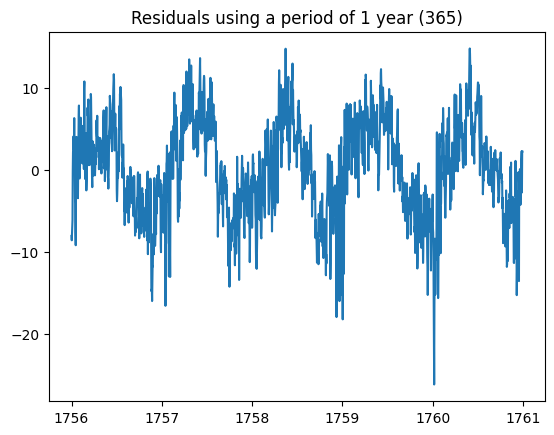

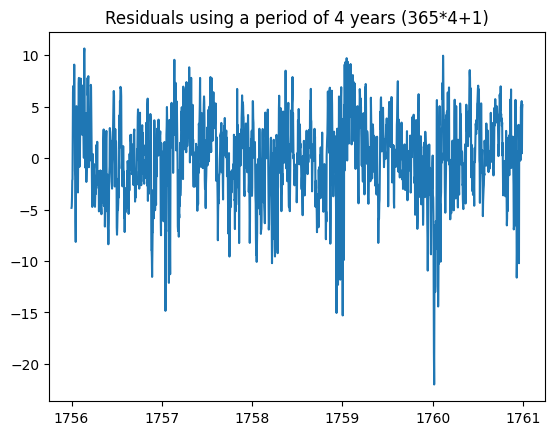

In [64]:
plt.plot(seas_decompose_1_year.resid.head(365*5).index,seas_decompose_1_year.resid.head(365*5))
plt.title("Residuals using a period of 1 year (365)")
plt.show()
plt.plot(seas_decompose_4_years.resid.head(365*5).index,seas_decompose_4_years.resid.head(365*5))
plt.title("Residuals using a period of 4 years (365*4+1)")
plt.show()

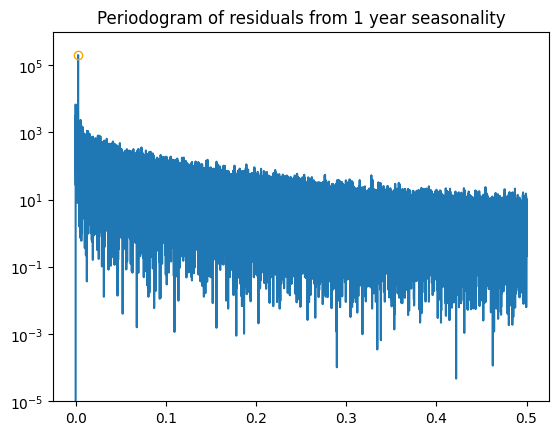

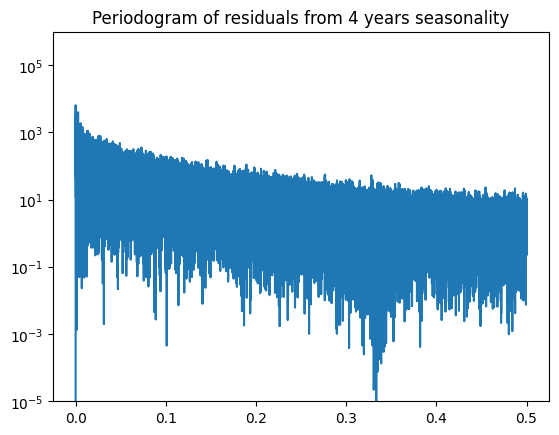

In [65]:
f, px =periodogram(seas_decompose_1_year.resid)
plt.plot(f,px)
plt.title("Periodogram of residuals from 1 year seasonality")
plt.yscale("log")
plt.ylim([1E-5,1E6])
max_p=np.max(px)
max_f=f[np.argmax(px)]
plt.plot(max_f,max_p,'o',markerfacecolor='none',markeredgecolor='orange')
plt.show()
f, px =periodogram(seas_decompose_4_years.resid)
plt.plot(f,px)
plt.title("Periodogram of residuals from 4 years seasonality")
plt.yscale("log")
plt.ylim([1E-5,1E6])
plt.show()

In [66]:
data_cleaned=seas_decompose_4_years.resid

## Fitting ARMA Models

In [67]:
# TODO